In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv('data/data_set.csv')

In [4]:
print(df.head())

   step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT    9839.64  C1231006815       170136.0       160296.36   
1     1   CASH_IN  143236.26  C1862994526            0.0       143236.26   
2     1  TRANSFER     181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT     181.00   C840083671          181.0            0.00   
4     1     DEBIT    5337.77   C712410124        41720.0        36382.23   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155            0.00            0.00        0               0  
1  C1688019098       608932.17        97263.78        0               0  
2   C553264065            0.00            0.00        1               0  
3    C38997010        21182.00            0.00        1               0  
4   C195600860        41898.00        40348.79        0               0  


In [18]:
df['type'] = df['type'].replace({'PAYMENT': 'Ödeme', 'CASH_OUT': 'Nakit Çıkış', 'CASH_IN': 'Nakit Giriş', 'TRANSFER': 'Transfer', 'DEBIT': 'Havale'})

type = df["type"].value_counts()
transactions = type.index
quantity = type.values

import plotly .express as px
figure = px.pie(df, values=quantity, names=transactions, hole=0.5, title="İşlem Türlerinin Dağılımı")
figure.show()


In [5]:
#Rastgele 10 veriyi çek
df.sample(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
11506,7,PAYMENT,6859.89,C1598849823,243678.00,236818.11,M1463924746,0.00,0.00,0,0
43982,9,TRANSFER,415115.86,C826043058,0.00,0.00,C1576408634,745744.95,1160860.81,0,0
25561,8,CASH_OUT,96716.58,C1870961885,4563.00,0.00,C187019413,158412.12,384209.88,0,0
1621,1,PAYMENT,1635.86,C1074844820,0.00,0.00,M874153561,0.00,0.00,0,0
20354,8,PAYMENT,2915.49,C559428507,13118.00,10202.51,M1721041839,0.00,0.00,0,0
13460,7,PAYMENT,871.51,C840051411,43633.00,42761.49,M1091459664,0.00,0.00,0,0
11223,7,CASH_OUT,164672.33,C1704496975,1424.93,0.00,C2052185144,947554.33,951130.52,0,0
12554,7,TRANSFER,957116.22,C2053764323,0.00,0.00,C8290162,3011570.02,6650282.66,0,0
3942,3,CASH_IN,53594.23,C436028378,4417812.72,4471406.95,C317071334,139555.44,85961.20,0,0
29129,8,CASH_IN,99356.76,C565212821,17620187.05,17719543.81,C1987564320,324814.37,225457.61,0,0


In [6]:
df.shape

(50000, 11)

<Axes: >

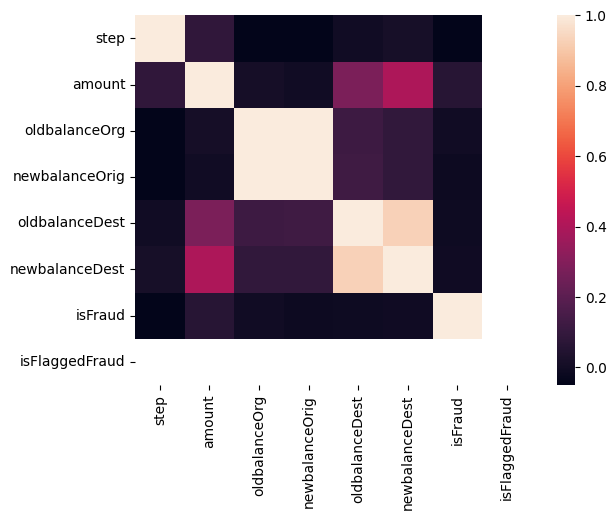

In [11]:
sns.heatmap(df.corr(numeric_only=True))

In [8]:
print(df.type.value_counts())

type
PAYMENT     21912
CASH_OUT    13756
CASH_IN      8992
TRANSFER     4700
DEBIT         640
Name: count, dtype: int64


In [10]:
df_numeric = df.select_dtypes(include=['number'])

correlation = df_numeric.corr()

# isFraud sütununun diğer sütunlarla korelasyonunu yazdırma
print(correlation['isFraud'].sort_values(ascending=False))




isFraud           1.000000
amount            0.057639
oldbalanceOrg    -0.003010
newbalanceDest   -0.007744
oldbalanceDest   -0.011924
newbalanceOrig   -0.014349
step             -0.049929
isFlaggedFraud         NaN
Name: isFraud, dtype: float64


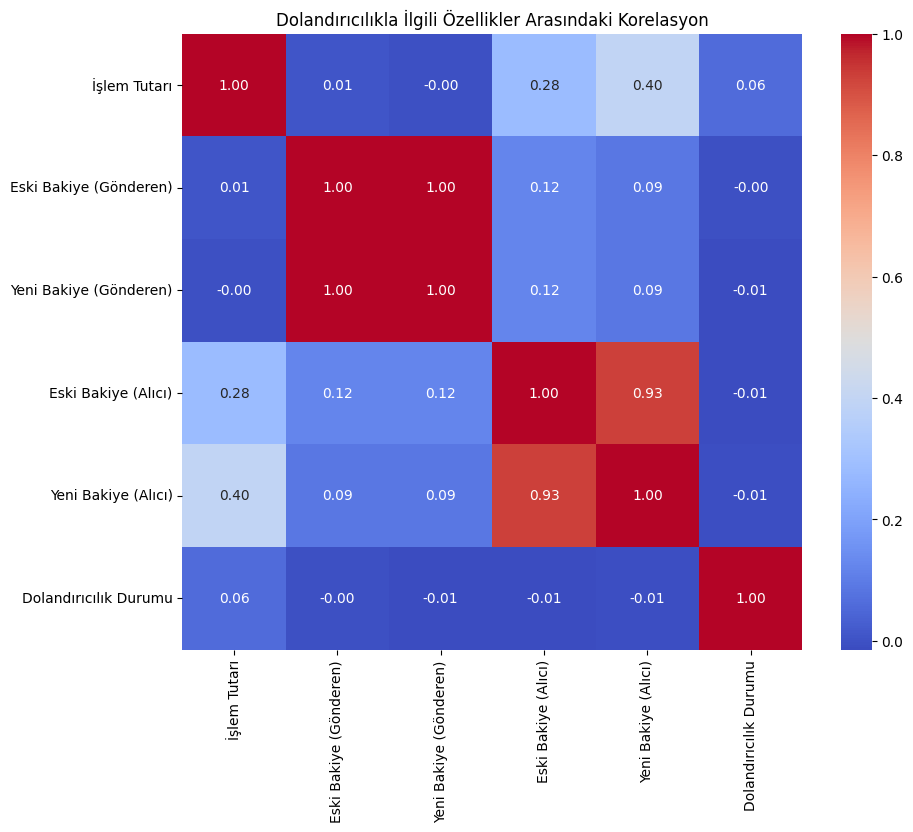

In [12]:
df_fraud_related = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']]
df_fraud_related.columns = ['İşlem Tutarı', 'Eski Bakiye (Gönderen)', 'Yeni Bakiye (Gönderen)', 'Eski Bakiye (Alıcı)', 'Yeni Bakiye (Alıcı)', 'Dolandırıcılık Durumu']

correlation = df_fraud_related.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Dolandırıcılıkla İlgili Özellikler Arasındaki Korelasyon')
plt.show()


In [13]:
fraud_rate = df['isFraud'].mean()
print("Dolandırıcılık Oranı:", fraud_rate)


Dolandırıcılık Oranı: 0.002


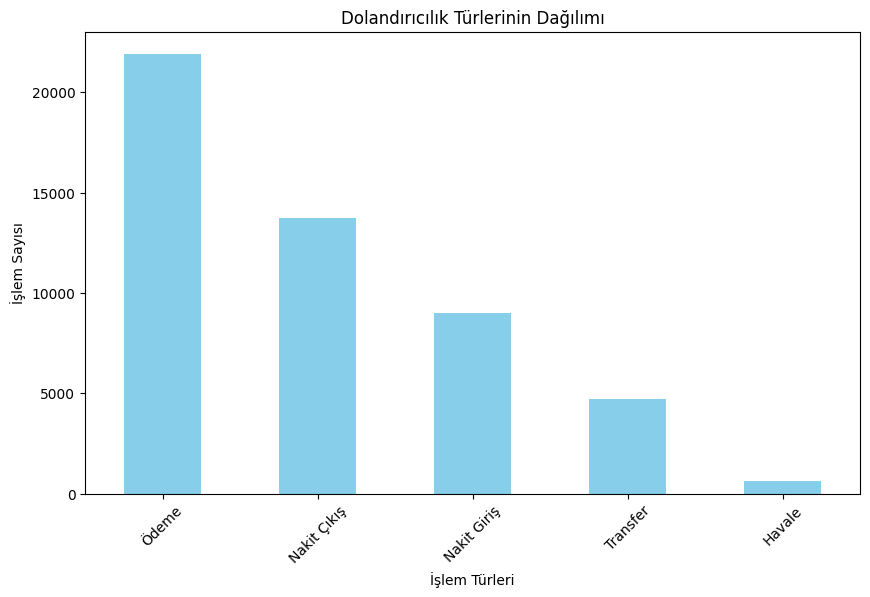

In [14]:
plt.figure(figsize=(10, 6))
df['type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Dolandırıcılık Türlerinin Dağılımı')
plt.xlabel('İşlem Türleri')
plt.ylabel('İşlem Sayısı')
plt.xticks(rotation=45)
plt.show()

In [15]:
# 'Transfer' ve 'Nakit Çıkış' işlemlerinin dolandırıcılık oranını karşılaştırma
fraud_by_type = df.groupby('type')['isFraud'].mean()
print(fraud_by_type)


type
Havale         0.000000
Nakit Giriş    0.000000
Nakit Çıkış    0.003707
Transfer       0.010426
Ödeme          0.000000
Name: isFraud, dtype: float64


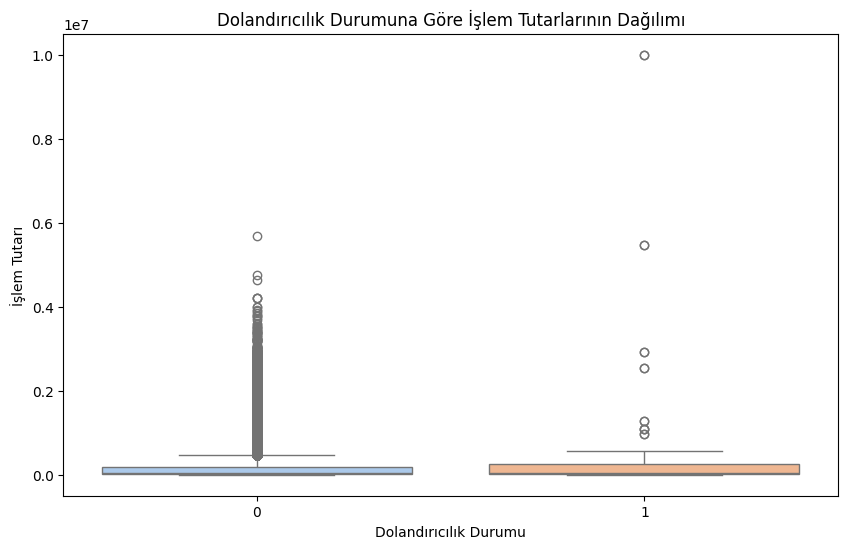

In [16]:
# Dolandırıcılık durumuna göre işlem tutarlarının dağılım grafiği
plt.figure(figsize=(10, 6))
sns.boxplot(x='isFraud', y='amount', hue='isFraud', data=df, palette='pastel', legend=False)
plt.title('Dolandırıcılık Durumuna Göre İşlem Tutarlarının Dağılımı')
plt.xlabel('Dolandırıcılık Durumu')
plt.ylabel('İşlem Tutarı')
plt.show()
